In [1]:
#PyQt of 3 element filter with graph and sliders 

In [3]:
pip install pyqt5 opencv-python-headless numpy tifffile


Note: you may need to restart the kernel to use updated packages.


In [1]:
# #Old Code Mouse data appears on the side
# import os
# import sys
# import cv2
# import numpy as np
# import tifffile as tiff
# from PyQt5.QtWidgets import (
#     QApplication, QLabel, QWidget, QVBoxLayout,
#     QPushButton, QHBoxLayout
# )
# from PyQt5.QtGui import QPixmap, QImage, QPainter, QColor, QPen
# from PyQt5.QtCore import Qt

# # === Set QT plugin path (needed for conda users) ===
# os.environ["QT_QPA_PLATFORM_PLUGIN_PATH"] = os.path.join(
#     os.environ["CONDA_PREFIX"], "lib", "qt", "plugins"
# )

# # === Image paths ===
# img_r_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_Fe_merged.tiff"
# img_g_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_Ca_merged.tiff"
# img_b_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_S_merged.tiff"

# # === Helper: normalize and dilate image ===
# def normalize_and_dilate(img):
#     img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
#     norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#     dilated = cv2.dilate(norm, np.ones((5, 5), np.uint8), iterations=3)
#     return norm, dilated

# # === Helper: blob detection ===
# def detect_blobs(img_norm, img_orig, min_thresh):
#     params = cv2.SimpleBlobDetector_Params()
#     params.minThreshold = min_thresh
#     params.maxThreshold = 255
#     params.filterByArea = True
#     params.minArea = 200
#     params.maxArea = 50000
#     params.filterByCircularity = False
#     params.filterByConvexity = False
#     params.filterByInertia = False
#     params.filterByColor = True
#     params.blobColor = 255
#     detector = cv2.SimpleBlobDetector_create(params)

#     keypoints = detector.detect(img_norm)
#     blobs = []
#     for kp in keypoints:
#         x, y = int(kp.pt[0]), int(kp.pt[1])
#         radius = int(kp.size / 2)
#         mask = np.zeros(img_orig.shape, dtype=np.uint8)
#         cv2.rectangle(mask, (x - radius, y - radius), (x + radius, y + radius), 255, thickness=-1)
#         vals = img_orig[mask == 255]
#         vals_dilated = img_norm[mask == 255]
#         if vals.size > 0:
#             blobs.append({
#                 'center': (x, y),
#                 'radius': radius,
#                 'size': kp.size,
#                 'max_intensity': vals.max(),
#                 'mean_intensity': vals.mean(),
#                 'mean_dilation': float(vals_dilated.mean())
#             })
#     return blobs

# # === Load TIFF images and process ===
# img_r = tiff.imread(img_r_path).astype(np.float32)
# img_g = tiff.imread(img_g_path).astype(np.float32)
# img_b = tiff.imread(img_b_path).astype(np.float32)

# img_r_norm, img_r_dilated = normalize_and_dilate(img_r)
# img_g_norm, img_g_dilated = normalize_and_dilate(img_g)
# img_b_norm, img_b_dilated = normalize_and_dilate(img_b)

# blobs_r = detect_blobs(img_r_dilated, img_r, min_thresh=100)
# blobs_g = detect_blobs(img_g_dilated, img_g, min_thresh=100)
# blobs_b = detect_blobs(img_b_dilated, img_b, min_thresh=100)

# img_r_disp = cv2.normalize(img_r, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# img_g_disp = cv2.normalize(img_g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# img_b_disp = cv2.normalize(img_b, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# # === Merge channels to RGB ===
# merged_rgb = cv2.merge([img_r_disp, img_g_disp, img_b_disp])  # [R, G, B]

# # === Convert to QImage ===
# height, width, channel = merged_rgb.shape
# bytes_per_line = 3 * width
# q_img = QImage(merged_rgb.data, width, height, bytes_per_line, QImage.Format_RGB888)

# # === Draw bounding boxes on top ===
# q_img_painted = QImage(q_img)  # Copy image for painting
# painter = QPainter(q_img_painted)

# pen_r = QPen(QColor("red"), 2)
# pen_g = QPen(QColor("green"), 2)
# pen_b = QPen(QColor("blue"), 2)

# for blob in blobs_r:
#     x, y = blob['center']
#     r = blob['radius']
#     painter.setPen(pen_r)
#     painter.drawRect(x - r, y - r, 2 * r, 2 * r)

# for blob in blobs_g:
#     x, y = blob['center']
#     r = blob['radius']
#     painter.setPen(pen_g)
#     painter.drawRect(x - r, y - r, 2 * r, 2 * r)

# for blob in blobs_b:
#     x, y = blob['center']
#     r = blob['radius']
#     painter.setPen(pen_b)
#     painter.drawRect(x - r, y - r, 2 * r, 2 * r)

# painter.end()

# # === Hover-capable QLabel ===
# class HoverLabel(QLabel):
#     def __init__(self, coord_display_label, blobs_r, blobs_g, blobs_b):
#         super().__init__()
#         self.coord_display_label = coord_display_label
#         self.setMouseTracking(True)
#         self.blobs = {
#             "Fe (Red)": blobs_r,
#             "Ca (Green)": blobs_g,
#             "S (Blue)": blobs_b
#         }

#     def mouseMoveEvent(self, event):
#         x = event.pos().x()
#         y = event.pos().y()
#         label = f"X: {x}, Y: {y}"

#         for element_name, blob_list in self.blobs.items():
#             for blob in blob_list:
#                 bx, by = blob['center']
#                 r = blob['radius']
#                 if (bx - r) <= x <= (bx + r) and (by - r) <= y <= (by + r):
#                     box_x, box_y = bx - r, by - r
#                     box_size = 2 * r
#                     label = (
#                         f"<b>{element_name}</b><br>"
#                         f"Mouse: ({x}, {y})<br>"
#                         f"Center: ({bx}, {by})<br>"
#                         f"Top-left: ({box_x}, {box_y})<br>"
#                         f"Box size: {box_size} x {box_size} px<br>"
#                         f"Box area: {box_size * box_size} px²<br>"
#                         f"Max intensity: {blob['max_intensity']:.3f}<br>"
#                         f"Mean intensity: {blob['mean_intensity']:.3f}<br>"
#                         f"Mean dilation intensity: {blob['mean_dilation']:.1f}"
#                     )
#                     break
#             else:
#                 continue
#             break

#         self.coord_display_label.setText(label)

# # === GUI Setup ===
# app = QApplication(sys.argv)
# window = QWidget()
# window.setWindowTitle("Merged TIFF Image with Blob Bounding Boxes")

# main_layout = QHBoxLayout()

# # === Coordinate label ===
# coord_label = QLabel("Hover to see coordinates")
# coord_label.setStyleSheet("font-size: 13px; padding: 4px;")
# coord_label.setTextFormat(Qt.RichText)

# # === Image area with hover tracking ===
# image_label = HoverLabel(coord_label, blobs_r, blobs_g, blobs_b)
# image_label.setPixmap(QPixmap.fromImage(q_img_painted))
# main_layout.addWidget(image_label)

# # === Control panel ===
# control_panel = QWidget()
# control_panel.setStyleSheet("background-color: white;")
# control_layout = QVBoxLayout()

# # Exit button
# exit_btn = QPushButton("Exit")
# exit_btn.setFixedWidth(100)
# exit_btn.clicked.connect(window.close)
# control_layout.addWidget(exit_btn)

# # Coordinate display
# control_layout.addWidget(coord_label)
# control_layout.addStretch()

# control_panel.setLayout(control_layout)
# main_layout.addWidget(control_panel)

# # Final layout
# window.setLayout(main_layout)
# window.show()
# sys.exit(app.exec_())


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


SystemExit: 0

/home/codingcarlos/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:

img_r_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_Fe_merged.tiff"
img_g_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_Ca_merged.tiff"
img_b_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_S_merged.tiff"

img_r_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_175um_stitched/S.tiff"
img_g_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_175um_stitched/Al.tiff"
img_b_path = "/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_175um_stitched/Fe.tiff"

In [ ]:
# min area 200


In [ ]:
#Added checklist 

In [1]:
# import os
# import sys
# import cv2
# import numpy as np
# import tifffile as tiff
# from PyQt5.QtWidgets import (
#     QApplication, QLabel, QWidget, QVBoxLayout, QHBoxLayout,
#     QPushButton, QGraphicsView, QGraphicsScene, QGraphicsPixmapItem,
#     QCheckBox, QSlider, QFileDialog, QListWidget, QListWidgetItem, 
#     QMessageBox, QDoubleSpinBox, QProgressBar
# )
# from PyQt5.QtGui import QPixmap, QImage, QPainter, QColor, QPen
# from PyQt5.QtCore import Qt
# from collections import Counter
# import time

# # Store paths selected by user
# img_paths = [None, None, None]  # [R, G, B]
# file_names = [None, None, None]
# element_colors = ["red", "green", "blue"]

# graphics_view = None
# controls_widget = None

# microns_per_pixel_x = 0.0
# microns_per_pixel_y = 0.0

# true_origin_x = 0.0
# true_origin_y = 0.0

# def on_dir_selected():
#     directory = QFileDialog.getExistingDirectory(window, "Select Directory")
#     if not directory:
#         return

#     all_files = sorted(os.listdir(directory))  # Alphabetical (case-sensitive)
#     file_list_widget.clear()
#     file_paths.clear()

#     for fname in all_files:
#         full_path = os.path.join(directory, fname)
#         if os.path.isfile(full_path):
#             item = QListWidgetItem(f"{fname} ({os.path.splitext(fname)[1][1:].upper()})")
#             item.setCheckState(Qt.Unchecked)
#             file_list_widget.addItem(item)
#             file_paths.append(full_path)

# # Keep these global to track order of selection
# selected_files_order = []  # store indices of items checked, in order

# def update_selection():
#     global selected_files_order

#     # Check which items are checked currently
#     checked_indices = [i for i in range(file_list_widget.count()) if file_list_widget.item(i).checkState() == Qt.Checked]

#     # Find newly checked or unchecked items by comparing to stored order
#     # Remove unchecked items from order
#     selected_files_order = [i for i in selected_files_order if i in checked_indices]

#     # Add newly checked items at the end
#     for i in checked_indices:
#         if i not in selected_files_order:
#             if len(selected_files_order) < 3:
#                 selected_files_order.append(i)
#             else:
#                 # Too many selected, uncheck this item immediately
#                 file_list_widget.item(i).setCheckState(Qt.Unchecked)

#     # If less than 3 selected, clear img_paths and file_names partially
#     for idx in range(3):
#         if idx < len(selected_files_order):
#             path = file_paths[selected_files_order[idx]]
#             img_paths[idx] = path
#             file_names[idx] = os.path.basename(path)
#         else:
#             img_paths[idx] = None
#             file_names[idx] = None
 
# def on_confirm_clicked():
#     global microns_per_pixel_x
#     microns_per_pixel_x = float_input_micron_x.value()
#     print(microns_per_pixel_x)
#     global microns_per_pixel_y
#     microns_per_pixel_y = float_input_micron_y.value()
#     print(microns_per_pixel_y)
#     global true_origin_x
#     true_origin_x = origin_x_input.value()
#     global true_origin_y
#     true_origin_y = origin_y_input.value()
#     print(true_origin_x)
#     print(true_origin_y)

#     if len(selected_files_order) != 3:
#         QMessageBox.warning(window, "Invalid Selection", "Please select exactly 3 items.")
#         return

#     init_gui()
        
# app = QApplication(sys.argv)
# window = QWidget()
# window.setWindowTitle("Multi-Element Image Analyzer")
# window.resize(600, 500)

# main_layout = QVBoxLayout()

# # Directory selector
# dir_button = QPushButton("Choose Directory")
# dir_button.clicked.connect(on_dir_selected)
# main_layout.addWidget(dir_button)

# # List of files in the selected directory
# file_list_widget = QListWidget()
# file_list_widget.setSelectionMode(QListWidget.NoSelection)
# file_list_widget.itemChanged.connect(update_selection)
# # Horizontal layout: file list on the left, confirm button on the right
# file_confirm_layout = QHBoxLayout()
# file_confirm_layout.addWidget(file_list_widget)

# # Right side (confirm button)
# right_panel = QVBoxLayout()
# confirm_button = QPushButton("Confirm Selection")
# confirm_button.clicked.connect(on_confirm_clicked)
# right_panel.addWidget(confirm_button)
# right_panel.addStretch()

# float_input_micron_x  = QDoubleSpinBox()
# float_input_micron_x.setPrefix("Enter X(µm) per pixel:")
# float_input_micron_x.setRange(0.0, 1000.0)         # Adjust range as needed
# float_input_micron_x.setSingleStep(0.1)            # Step size
# float_input_micron_x.setDecimals(3)                # Number of decimal places
# float_input_micron_x.setValue(1.0)                 # Default value
# right_panel.addWidget(float_input_micron_x)

# float_input_micron_y  = QDoubleSpinBox()
# float_input_micron_y.setPrefix("Enter Y(µm) per pixel:")
# float_input_micron_y.setRange(0.0, 1000.0)         # Adjust range as needed
# float_input_micron_y.setSingleStep(0.1)            # Step size
# float_input_micron_y.setDecimals(3)                # Number of decimal places
# float_input_micron_y.setValue(1.0)                 # Default value
# right_panel.addWidget(float_input_micron_y)

# origin_x_input = QDoubleSpinBox()
# origin_x_input.setPrefix("Origin X(µm): ")
# origin_x_input.setRange(-1e6, 1e6)
# origin_x_input.setDecimals(2)
# origin_x_input.setValue(0.0)                 # Default value

# origin_y_input = QDoubleSpinBox()
# origin_y_input.setPrefix("Origin Y(µm): ")
# origin_y_input.setRange(-1e6, 1e6)
# origin_y_input.setDecimals(2)
# origin_x_input.setValue(0.0)                 # Default value

# right_panel.addWidget(origin_x_input)
# right_panel.addWidget(origin_y_input)

# file_confirm_layout.addLayout(right_panel)

# main_layout.addLayout(file_confirm_layout)

# # Track full file paths
# file_paths = []

# # === Defer the rest of the UI until files are selected ===
# def init_gui():       
#     # for btn in buttons:
#     #     btn.setEnabled(False)

#     # Load and convert
#     global graphics_view, controls_widget

#     if graphics_view is not None:
#         main_layout.removeWidget(graphics_view)
#         graphics_view.setParent(None)
#         graphics_view.deleteLater()
#         graphics_view = None

#     if controls_widget is not None:
#         main_layout.removeWidget(controls_widget)
#         controls_widget.setParent(None)
#         controls_widget.deleteLater()
#         controls_widget = None
        
#     img_r, img_g, img_b = [tiff.imread(p).astype(np.float32) for p in img_paths]
    
#     # Resize to majority shape
#     shapes = [img_r.shape, img_g.shape, img_b.shape]
#     shape_counts = Counter(shapes)
#     target_shape = shape_counts.most_common(1)[0][0]
#     print(f"Target (majority) shape: {target_shape}")
    
#     def resize_if_needed(img, name):
#         if img.shape != target_shape:
#             print(f"Resizing {name} from {img.shape} → {target_shape}")
#             return cv2.resize(img, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_AREA)
#         return img
    
#     img_r = resize_if_needed(img_r, file_names[0])
#     img_g = resize_if_needed(img_g, file_names[1])
#     img_b = resize_if_needed(img_b, file_names[2])

#     def normalize_and_dilate(img):
#         img = np.nan_to_num(img)
#         norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#         dilated = cv2.dilate(norm, np.ones((5, 5), np.uint8), iterations=3)
#         return norm, dilated

#     def detect_blobs(img_norm, img_orig, min_thresh, min_area, color, file_name):
#         params = cv2.SimpleBlobDetector_Params()
#         params.minThreshold = min_thresh
#         params.maxThreshold = 255
#         params.filterByArea = True
#         params.minArea = min_area
#         params.maxArea = 50000
#         params.thresholdStep = 5  #Default was 10

#         params.filterByColor = False#True
#         # params.blobColor = 255
        
#         params.filterByCircularity = False
#         params.filterByInertia = False
#         params.filterByConvexity = False
#         params.minRepeatability = 1
        
#         detector = cv2.SimpleBlobDetector_create(params)
#         keypoints = detector.detect(img_norm)
#         blobs = []
#         for kp in keypoints:
#             x, y = int(kp.pt[0]), int(kp.pt[1])
#             radius = int(kp.size / 2)
#             box_size = 2 * radius
#             box_x, box_y = x - radius, y - radius
#             mask = np.zeros(img_orig.shape, dtype=np.uint8)
#             cv2.rectangle(mask, (box_x, box_y), (x + radius, y + radius), 255, thickness=-1)
#             vals = img_orig[mask == 255]
#             vals_dilated = img_norm[mask == 255]
#             if vals.size > 0:
#                 blobs.append({
#                     'center': (x, y),
#                     'radius': radius,
#                     'color': color,
#                     'file': file_name,
#                     'max_intensity': vals.max(),
#                     'mean_intensity': vals.mean(),
#                     'mean_dilation': float(vals_dilated.mean()),
#                     'box_x': box_x,
#                     'box_y': box_y,
#                     'box_size': box_size
#                 })
#         return blobs

#     norm_dilated = [normalize_and_dilate(im) for im in [img_r, img_g, img_b]]
#     normalized = [nd[0] for nd in norm_dilated]
#     dilated = [nd[1] for nd in norm_dilated]

#     thresholds_range = list(range(0, 256, 10))
#     area_range = list(range(10, 501, 10))

#     progress_bar = QProgressBar()
#     progress_bar.setRange(0, len(element_colors) * len(thresholds_range) * len(area_range))
#     progress_bar.setValue(0)
#     progress_bar.setTextVisible(True)
#     progress_bar.setFormat("Computing blobs... %p%")
#     main_layout.addWidget(progress_bar)
#     total_iterations = len(element_colors) * len(thresholds_range) * len(area_range)
#     current_iteration = 0
#     precomputed_blobs = {}
#     print(time.strftime('%H:%M:%S'))
#     for i, color in enumerate(element_colors):
#         precomputed_blobs[color] = {}
#         for t in thresholds_range:
#             for a in area_range:
#                 key = (t, a)
#                 result = detect_blobs(dilated[i], [img_r, img_g, img_b][i], t, a, color, file_names[i])
#                 precomputed_blobs[color][key] = result
    
#                 # Update progress
#                 current_iteration += 1
#                 progress_bar.setValue(current_iteration)
#                 QApplication.processEvents()  # Allows UI to update

#     # precomputed_blobs = {
#     #     color: {
#     #         (t, a): detect_blobs(dilated[i], [img_r, img_g, img_b][i], t, a, color, file_names[i])
#     #         for t in thresholds_range
#     #         for a in area_range
#     #     }
#     #     for i, color in enumerate(element_colors)
#     # }

#     progress_bar.hide()
#     print(time.strftime('%H:%M:%S'))
#     thresholds = {color: 100 for color in element_colors}
#     area_thresholds = {color: 200 for color in element_colors}

#     def get_current_blobs():
#         blobs = []
#         for color in element_colors:
#             thresh = thresholds[color]
#             area = area_thresholds[color]
            
#             # Snap area to nearest available area_range value (optional, if mismatch risk exists)
#             available_areas = list(range(10, 501, 10))
#             snapped_area = min(available_areas, key=lambda a: abs(a - area))
            
#             key = (thresh, snapped_area)
#             blobs_for_color = precomputed_blobs[color].get(key, [])
            
#             filtered = blobs_for_color  # no need to filter again, already done

#             blobs.extend(filtered)
#         return blobs
    
#     merged_rgb = cv2.merge([
#         cv2.normalize(img_r, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
#         cv2.normalize(img_g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
#         cv2.normalize(img_b, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#     ])

#     hover_label = QLabel()
#     hover_label.setWindowFlags(Qt.ToolTip)
#     hover_label.hide()

#     x_label = QLabel("X: 0")
#     y_label = QLabel("Y: 0")

#     x_micron_label = QLabel("X Real: 0")
#     y_micron_label = QLabel("Y Real: 0")
    
#     scene = QGraphicsScene()
#     q_img = QImage(merged_rgb.data, merged_rgb.shape[1], merged_rgb.shape[0], merged_rgb.shape[1] * 3, QImage.Format_RGB888)
#     pixmap_item = QGraphicsPixmapItem(QPixmap.fromImage(q_img))
#     scene.addItem(pixmap_item)

#     class ZoomableGraphicsView(QGraphicsView):
#         def __init__(self, scene, hover_label, x_label, y_label, x_micron_label, y_micron_label):
#             super().__init__(scene)
#             self.setRenderHints(QPainter.Antialiasing | QPainter.SmoothPixmapTransform)
#             self.setTransformationAnchor(QGraphicsView.AnchorUnderMouse)
#             self.setMouseTracking(True)
#             self.setDragMode(QGraphicsView.NoDrag)
#             self._drag_active = False
#             self.hover_label = hover_label
#             self.blobs = []
#             self.visible_colors = set(element_colors)
#             self.x_label = x_label
#             self.y_label = y_label
#             self.x_micron_label = x_micron_label
#             self.y_micron_label = y_micron_label

#         def wheelEvent(self, event):
#             cursor_pos = event.pos()
#             scene_pos = self.mapToScene(cursor_pos)
#             zoom_factor = 1.25 if event.angleDelta().y() > 0 else 0.8
#             self.scale(zoom_factor, zoom_factor)
#             mouse_centered = self.mapFromScene(scene_pos)
#             delta = cursor_pos - mouse_centered
#             self.horizontalScrollBar().setValue(self.horizontalScrollBar().value() - delta.x())
#             self.verticalScrollBar().setValue(self.verticalScrollBar().value() - delta.y())

#         def mousePressEvent(self, event):
#             if event.button() == Qt.LeftButton:
#                 self.setDragMode(QGraphicsView.ScrollHandDrag)
#                 self._drag_active = True
#             super().mousePressEvent(event)

#         def mouseReleaseEvent(self, event):
#             if event.button() == Qt.LeftButton:
#                 self.setDragMode(QGraphicsView.NoDrag)
#                 self._drag_active = False
#             super().mouseReleaseEvent(event)

#         def mouseMoveEvent(self, event):
#             if self._drag_active:
#                 super().mouseMoveEvent(event)
#                 return
#             pos = self.mapToScene(event.pos())
#             x, y = int(pos.x()), int(pos.y())
#             self.x_label.setText(f"X: {x}")
#             self.y_label.setText(f"Y: {y}")
#             self.x_micron_label.setText(f"X Real location(µm): {(x * microns_per_pixel_x) + true_origin_x:.2f}")
#             self.y_micron_label.setText(f"Y Real location(µm): {(y * microns_per_pixel_y) + true_origin_y:.2f}")
#             for blob in self.blobs:
#                 if blob['color'] not in self.visible_colors:
#                     continue
#                 cx, cy = blob['center']
#                 r = blob['radius']
#                 if abs(x - cx) <= r and abs(y - cy) <= r:
#                     html = (
#                         f"<b>{blob['color'].capitalize()} Element</b><br>"
#                         f"<i>{blob['file']}</i><br>"
#                         f"Center: ({cx}, {cy})<br>"
#                         f"Top-left: ({blob['box_x']}, {blob['box_y']})<br>"
#                         f"Box size: {blob['box_size']} x {blob['box_size']} px<br>"
#                         f"Box area: {blob['box_size'] * blob['box_size']} px²<br>"
#                         f"<br>"
#                         f"Real Center location(µm): ({(cx * microns_per_pixel_x) + true_origin_x:.2f} µm, {(cy * microns_per_pixel_y) + true_origin_y:.2f} µm)<br>"
#                         f"Real box size(µm): ({blob['box_size'] * microns_per_pixel_x:.2f} µm × {blob['box_size'] * microns_per_pixel_y:.2f} µm)<br>"
#                         f"Real box area(µm): ({blob['box_size']**2 * microns_per_pixel_x * microns_per_pixel_y:.2f} µm²)<br>"
#                         f"<br>"
#                         f"Max intensity: {blob['max_intensity']:.3f}<br>"
#                         f"Mean intensity: {blob['mean_intensity']:.3f}<br>"
#                         f"Mean dilation intensity: {blob['mean_dilation']:.1f}"
#                     )
#                     self.hover_label.setText(html)
#                     self.hover_label.adjustSize()
#                     self.hover_label.move(event.x() + 15, event.y() - 30)
#                     self.hover_label.setStyleSheet(
#                         f"background-color: {blob['color']}; color: white; border: 1px solid black; padding: 4px;"
#                     )
#                     self.hover_label.show()
#                     return
#             self.hover_label.hide()

#         def update_blobs(self, blobs, visible_colors):
#             self.blobs = blobs
#             self.visible_colors = visible_colors

#     graphics_view = ZoomableGraphicsView(scene, hover_label, x_label, y_label, x_micron_label, y_micron_label)
#     main_layout.addWidget(graphics_view)
    
#     def redraw_boxes(blobs, selected_colors):
#         updated_img = QImage(ZoomableGraphicsView.current_qimage)
#         painter = QPainter(updated_img)
#         for blob in blobs:
#             if blob['color'] in selected_colors:
#                 cx, cy, r = *blob['center'], blob['radius']
#                 painter.setPen(QPen(QColor(blob['color']), 2))
#                 painter.drawRect(cx - r, cy - r, 2 * r, 2 * r)
#         painter.end()
#         pixmap_item.setPixmap(QPixmap.fromImage(updated_img))

#     checkboxes = {}
#     selected_colors = set(element_colors)

#     def update_boxes():
#         nonlocal selected_colors
#         selected_colors = {c for c, cb in checkboxes.items() if cb.isChecked()}
#         blobs = [b for b in get_current_blobs() if b['color'] in selected_colors]
#         graphics_view.update_blobs(blobs, selected_colors)
#         redraw_boxes(blobs, selected_colors)
#         hover_label.hide()

#     legend_layout = QVBoxLayout()
#     legend_label = QLabel("Legend")
#     legend_label.setStyleSheet("font-weight: bold; font-size: 12pt;")
#     legend_layout.addWidget(legend_label)
#     for i, color in enumerate(element_colors):
#         cb = QCheckBox(file_names[i])
#         cb.setChecked(True)
#         cb.setStyleSheet(f"color: {color}")
#         cb.stateChanged.connect(update_boxes)
#         checkboxes[color] = cb
#         legend_layout.addWidget(cb)
#     legend_layout.addStretch()

#     sliders = {}
#     slider_labels = {}
#     slider_layout = QHBoxLayout()

#     def on_slider_change(value, color):
#         snapped = round(value / 10) * 10
#         snapped = max(0, min(250, snapped))
#         if thresholds[color] != snapped:
#             thresholds[color] = snapped
#             sliders[color].blockSignals(True)
#             sliders[color].setValue(snapped)
#             sliders[color].blockSignals(False)
#             slider_labels[color].setText(f"{checkboxes[color].text()}_threshold: {snapped}")
#             update_boxes()
        
#     for color in element_colors:
#         i = element_colors.index(color)
#         vbox = QVBoxLayout()
#         label = QLabel(f"{file_names[i]}_threshold: {thresholds[color]}")
#         slider = QSlider(Qt.Horizontal)
#         slider.setMinimum(0)
#         slider.setMaximum(255)
#         slider.setTickInterval(10)
#         slider.setValue(thresholds[color])
#         slider.setTickPosition(QSlider.TicksBelow)
#         slider.valueChanged.connect(lambda val, c=color: on_slider_change(val, c))
#         sliders[color] = slider
#         slider_labels[color] = label
#         vbox.addWidget(label)
#         vbox.addWidget(slider)
#         slider_layout.addLayout(vbox)

#     area_sliders = {}
#     area_slider_labels = {}
    
#     def on_area_slider_change(value, color):
#         valid_areas = list(range(10, 401, 10)) 
#         snapped = min(valid_areas, key=lambda a: abs(a - value))
#         if area_thresholds[color] != snapped:
#             area_thresholds[color] = snapped
#             area_sliders[color].blockSignals(True)
#             area_sliders[color].setValue(snapped)
#             area_sliders[color].blockSignals(False)
#             area_slider_labels[color].setText(f"{checkboxes[color].text()}_min_area: {snapped}")
#             update_boxes()


#     area_slider_layout = QHBoxLayout()
    
#     for color in element_colors:
#         i = element_colors.index(color)
#         vbox = QVBoxLayout()
#         label = QLabel(f"{file_names[i]}_min_area: {area_thresholds[color]}")
#         slider = QSlider(Qt.Horizontal)
#         slider.setMinimum(10)
#         slider.setMaximum(400)
#         slider.setTickInterval(10)
#         slider.setValue(area_thresholds[color])
#         slider.setTickPosition(QSlider.TicksBelow)
#         slider.valueChanged.connect(lambda val, c=color: on_area_slider_change(val, c))
#         area_sliders[color] = slider
#         area_slider_labels[color] = label
#         vbox.addWidget(label)
#         vbox.addWidget(slider)
#         area_slider_layout.addLayout(vbox)

#     exit_btn = QPushButton("Exit")
#     exit_btn.clicked.connect(window.close)
#     reset_btn = QPushButton("Reset View")
#     reset_btn.clicked.connect(lambda: graphics_view.resetTransform())

#     controls = QVBoxLayout()
#     controls.addWidget(exit_btn)
#     controls.addWidget(reset_btn)
#     controls.addLayout(legend_layout)
#     controls.addLayout(slider_layout)
#     controls.addLayout(area_slider_layout)
#     controls.addWidget(x_label)
#     controls.addWidget(y_label)
#     controls.addWidget(x_micron_label)
#     controls.addWidget(y_micron_label)

#     layout = QHBoxLayout()
#     layout.addWidget(graphics_view)
#     side_panel = QWidget()
#     side_panel.setLayout(controls)
#     controls_widget = side_panel
#     layout.addWidget(side_panel)

#     main_layout.addLayout(layout)
#     hover_label.setParent(window)

#     blobs = get_current_blobs()
#     graphics_view.update_blobs(blobs, selected_colors)
#     redraw_boxes(blobs, selected_colors)
#     window.resize(1200, 800)

# window.setLayout(main_layout)
# window.show()
# sys.exit(app.exec_())


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.
qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1

1.0
1.0
0.0
0.0
Target (majority) shape: (1039, 1039)
11:40:33
11:44:32


SystemExit: 0

/home/codingcarlos/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#reason it is runinng slow is because threshold step is set to 1 instead of the default 10 ^^^^^^^

In [ ]:
#Trying tricks to improve speed

In [1]:
import os
import sys
import cv2
import numpy as np
import tifffile as tiff
from PyQt5.QtWidgets import (
    QApplication, QLabel, QWidget, QVBoxLayout, QHBoxLayout,
    QPushButton, QGraphicsView, QGraphicsScene, QGraphicsPixmapItem,
    QCheckBox, QSlider, QFileDialog, QListWidget, QListWidgetItem, 
    QMessageBox, QDoubleSpinBox, QProgressBar, QScrollArea, QSizePolicy
)
from PyQt5.QtGui import QPixmap, QImage, QPainter, QColor, QPen
from PyQt5.QtCore import Qt, QRect
from collections import Counter
import time

# Store paths selected by user
img_paths = [None, None, None]  # [R, G, B]
file_names = [None, None, None]
element_colors = ["red", "green", "blue"]

graphics_view = None
controls_widget = None

microns_per_pixel_x = 0.0
microns_per_pixel_y = 0.0

true_origin_x = 0.0
true_origin_y = 0.0

def on_dir_selected():
    directory = QFileDialog.getExistingDirectory(window, "Select Directory")
    if not directory:
        return

    all_files = sorted(os.listdir(directory))  # Alphabetical (case-sensitive)
    file_list_widget.clear()
    file_paths.clear()

    for fname in all_files:
        full_path = os.path.join(directory, fname)
        if os.path.isfile(full_path):
            item = QListWidgetItem(f"{fname} ({os.path.splitext(fname)[1][1:].upper()})")
            item.setCheckState(Qt.Unchecked)
            file_list_widget.addItem(item)
            file_paths.append(full_path)

# Keep these global to track order of selection
selected_files_order = []  # store indices of items checked, in order

def update_selection():
    global selected_files_order

    # Check which items are checked currently
    checked_indices = [i for i in range(file_list_widget.count()) if file_list_widget.item(i).checkState() == Qt.Checked]

    # Find newly checked or unchecked items by comparing to stored order
    # Remove unchecked items from order
    selected_files_order = [i for i in selected_files_order if i in checked_indices]

    # Add newly checked items at the end
    for i in checked_indices:
        if i not in selected_files_order:
            if len(selected_files_order) < 3:
                selected_files_order.append(i)
            else:
                # Too many selected, uncheck this item immediately
                file_list_widget.item(i).setCheckState(Qt.Unchecked)

    # If less than 3 selected, clear img_paths and file_names partially
    for idx in range(3):
        if idx < len(selected_files_order):
            path = file_paths[selected_files_order[idx]]
            img_paths[idx] = path
            file_names[idx] = os.path.basename(path)
        else:
            img_paths[idx] = None
            file_names[idx] = None
 
def on_confirm_clicked():
    global microns_per_pixel_x
    microns_per_pixel_x = float_input_micron_x.value()
    print(microns_per_pixel_x)
    global microns_per_pixel_y
    microns_per_pixel_y = float_input_micron_y.value()
    print(microns_per_pixel_y)
    global true_origin_x
    true_origin_x = origin_x_input.value()
    global true_origin_y
    true_origin_y = origin_y_input.value()
    print(true_origin_x)
    print(true_origin_y)

    if len(selected_files_order) != 3:
        QMessageBox.warning(window, "Invalid Selection", "Please select exactly 3 items.")
        return

    init_gui()
        
app = QApplication(sys.argv)
window = QWidget()
window.setWindowTitle("Multi-Element Image Analyzer")
window.resize(600, 500)

main_layout = QVBoxLayout()

# Directory selector
dir_button = QPushButton("Choose Directory")
dir_button.clicked.connect(on_dir_selected)
main_layout.addWidget(dir_button)

# List of files in the selected directory
file_list_widget = QListWidget()
file_list_widget.setSelectionMode(QListWidget.NoSelection)
file_list_widget.itemChanged.connect(update_selection)
# Horizontal layout: file list on the left, confirm button on the right
file_confirm_layout = QHBoxLayout()
file_confirm_layout.addWidget(file_list_widget)

# Right side (confirm button)
right_panel = QVBoxLayout()
confirm_button = QPushButton("Confirm Selection")
confirm_button.clicked.connect(on_confirm_clicked)
right_panel.addWidget(confirm_button)
right_panel.addStretch()

float_input_micron_x  = QDoubleSpinBox()
float_input_micron_x.setPrefix("Enter X(µm) per pixel:")
float_input_micron_x.setRange(0.0, 1000.0)         # Adjust range as needed
float_input_micron_x.setSingleStep(0.1)            # Step size
float_input_micron_x.setDecimals(3)                # Number of decimal places
float_input_micron_x.setValue(1.0)                 # Default value
right_panel.addWidget(float_input_micron_x)

float_input_micron_y  = QDoubleSpinBox()
float_input_micron_y.setPrefix("Enter Y(µm) per pixel:")
float_input_micron_y.setRange(0.0, 1000.0)         # Adjust range as needed
float_input_micron_y.setSingleStep(0.1)            # Step size
float_input_micron_y.setDecimals(3)                # Number of decimal places
float_input_micron_y.setValue(1.0)                 # Default value
right_panel.addWidget(float_input_micron_y)

origin_x_input = QDoubleSpinBox()
origin_x_input.setPrefix("Origin X(µm): ")
origin_x_input.setRange(-1e6, 1e6)
origin_x_input.setDecimals(2)
origin_x_input.setValue(0.0)                 # Default value

origin_y_input = QDoubleSpinBox()
origin_y_input.setPrefix("Origin Y(µm): ")
origin_y_input.setRange(-1e6, 1e6)
origin_y_input.setDecimals(2)
origin_x_input.setValue(0.0)                 # Default value

right_panel.addWidget(origin_x_input)
right_panel.addWidget(origin_y_input)

file_confirm_layout.addLayout(right_panel)

main_layout.addLayout(file_confirm_layout)

# Track full file paths
file_paths = []

# Global list to store hoverable union boxes
global_union_boxes = []

# === Defer the rest of the UI until files are selected ===
def init_gui():       
    # for btn in buttons:
    #     btn.setEnabled(False)

    # Load and convert
    global graphics_view, controls_widget

    if graphics_view is not None:
        main_layout.removeWidget(graphics_view)
        graphics_view.setParent(None)
        graphics_view.deleteLater()
        graphics_view = None

    if controls_widget is not None:
        main_layout.removeWidget(controls_widget)
        controls_widget.setParent(None)
        controls_widget.deleteLater()
        controls_widget = None
        
    img_r, img_g, img_b = [tiff.imread(p).astype(np.float32) for p in img_paths]
    
    # Resize to majority shape
    shapes = [img_r.shape, img_g.shape, img_b.shape]
    shape_counts = Counter(shapes)
    target_shape = shape_counts.most_common(1)[0][0]
    print(f"Target (majority) shape: {target_shape}")
    
    def resize_if_needed(img, name):
        if img.shape != target_shape:
            print(f"Resizing {name} from {img.shape} → {target_shape}")
            return cv2.resize(img, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_AREA)
        return img
    
    img_r = resize_if_needed(img_r, file_names[0])
    img_g = resize_if_needed(img_g, file_names[1])
    img_b = resize_if_needed(img_b, file_names[2])

    def normalize_and_dilate(img):
        img = np.nan_to_num(img)
        norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        dilated = cv2.dilate(norm, np.ones((5, 5), np.uint8), iterations=3)
        return norm, dilated

    def detect_blobs(img_norm, img_orig, min_thresh, min_area, color, file_name):
        params = cv2.SimpleBlobDetector_Params()
        params.minThreshold = min_thresh
        params.maxThreshold = 255
        params.filterByArea = True
        params.minArea = min_area
        params.maxArea = 50000
        params.thresholdStep = 5  #Default was 10

        params.filterByColor = False#True
        # params.blobColor = 255
        
        params.filterByCircularity = False
        params.filterByInertia = False
        params.filterByConvexity = False
        params.minRepeatability = 1
        
        detector = cv2.SimpleBlobDetector_create(params)
        keypoints = detector.detect(img_norm)
        blobs = []
        for kp in keypoints:
            x, y = int(kp.pt[0]), int(kp.pt[1])
            radius = int(kp.size / 2)
            box_size = 2 * radius
            box_x, box_y = x - radius, y - radius

            x1, y1 = max(0, box_x), max(0, box_y)
            x2, y2 = min(img_orig.shape[1], x + radius), min(img_orig.shape[0], y + radius)
            roi_orig = img_orig[y1:y2, x1:x2]
            roi_dilated = img_norm[y1:y2, x1:x2]

            if roi_orig.size > 0:
                blobs.append({
                    'center': (x, y),
                    'radius': radius,
                    'color': color,
                    'file': file_name,
                    'max_intensity': roi_orig.max(),
                    'mean_intensity': roi_orig.mean(),
                    'mean_dilation': float(roi_dilated.mean()),
                    'box_x': box_x,
                    'box_y': box_y,
                    'box_size': box_size
                })
        return blobs

    norm_dilated = [normalize_and_dilate(im) for im in [img_r, img_g, img_b]]
    normalized = [nd[0] for nd in norm_dilated]
    dilated = [nd[1] for nd in norm_dilated]

    thresholds_range = list(range(0, 256, 10))
    area_range = list(range(10, 501, 10))

    progress_bar = QProgressBar()
    progress_bar.setRange(0, len(element_colors) * len(thresholds_range) * len(area_range))
    progress_bar.setValue(0)
    progress_bar.setTextVisible(True)
    progress_bar.setFormat("Computing blobs... %p%")
    main_layout.addWidget(progress_bar)
    total_iterations = len(element_colors) * len(thresholds_range) * len(area_range)
    current_iteration = 0
    precomputed_blobs = {}
    print(time.strftime('%H:%M:%S'))
    
    for i, color in enumerate(element_colors):
        precomputed_blobs[color] = {}
        for t in thresholds_range:
            for a in area_range:
                key = (t, a)
                result = detect_blobs(dilated[i], [img_r, img_g, img_b][i], t, a, color, file_names[i])
                precomputed_blobs[color][key] = result
    
                # Update progress
                current_iteration += 1
                progress_bar.setValue(current_iteration)
                QApplication.processEvents()  # Allows UI to update

    # precomputed_blobs = {
    #     color: {
    #         (t, a): detect_blobs(dilated[i], [img_r, img_g, img_b][i], t, a, color, file_names[i])
    #         for t in thresholds_range
    #         for a in area_range
    #     }
    #     for i, color in enumerate(element_colors)
    # }

    progress_bar.hide()
    print(time.strftime('%H:%M:%S'))
    thresholds = {color: 100 for color in element_colors}
    area_thresholds = {color: 200 for color in element_colors}

    def get_current_blobs():
        blobs = []
        for color in element_colors:
            thresh = thresholds[color]
            area = area_thresholds[color]
            
            # Snap area to nearest available area_range value (optional, if mismatch risk exists)
            available_areas = list(range(10, 501, 10))
            snapped_area = min(available_areas, key=lambda a: abs(a - area))
            
            key = (thresh, snapped_area)
            blobs_for_color = precomputed_blobs[color].get(key, [])
            
            filtered = blobs_for_color  # no need to filter again, already done

            blobs.extend(filtered)
        return blobs
    
    merged_rgb = cv2.merge([
        cv2.normalize(img_r, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
        cv2.normalize(img_g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
        cv2.normalize(img_b, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    ])

    hover_label = QLabel()
    hover_label.setWindowFlags(Qt.ToolTip)
    hover_label.hide()

    x_label = QLabel("X: 0")
    y_label = QLabel("Y: 0")

    x_micron_label = QLabel("X Real: 0")
    y_micron_label = QLabel("Y Real: 0")
    
    scene = QGraphicsScene()
    q_img = QImage(merged_rgb.data, merged_rgb.shape[1], merged_rgb.shape[0], merged_rgb.shape[1] * 3, QImage.Format_RGB888)

    class ZoomableGraphicsView(QGraphicsView):
        def __init__(self, scene, hover_label, x_label, y_label, x_micron_label, y_micron_label):
            super().__init__(scene)
            self.union_objects = []
            self.current_qimage = None
            self.setRenderHints(QPainter.Antialiasing | QPainter.SmoothPixmapTransform)
            self.setTransformationAnchor(QGraphicsView.AnchorUnderMouse)
            self.setMouseTracking(True)
            self.setDragMode(QGraphicsView.NoDrag)
            self._drag_active = False
            self.hover_label = hover_label
            self.blobs = []
            self.visible_colors = set(element_colors)
            self.x_label = x_label
            self.y_label = y_label
            self.x_micron_label = x_micron_label
            self.y_micron_label = y_micron_label

        def wheelEvent(self, event):
            cursor_pos = event.pos()
            scene_pos = self.mapToScene(cursor_pos)
            zoom_factor = 1.25 if event.angleDelta().y() > 0 else 0.8
            self.scale(zoom_factor, zoom_factor)
            mouse_centered = self.mapFromScene(scene_pos)
            delta = cursor_pos - mouse_centered
            self.horizontalScrollBar().setValue(self.horizontalScrollBar().value() - delta.x())
            self.verticalScrollBar().setValue(self.verticalScrollBar().value() - delta.y())

        def mousePressEvent(self, event):
            if event.button() == Qt.LeftButton:
                self.setDragMode(QGraphicsView.ScrollHandDrag)
                self._drag_active = True
            super().mousePressEvent(event)

        def mouseReleaseEvent(self, event):
            if event.button() == Qt.LeftButton:
                self.setDragMode(QGraphicsView.NoDrag)
                self._drag_active = False
            super().mouseReleaseEvent(event)

        def mouseMoveEvent(self, event):
            if self._drag_active:
                super().mouseMoveEvent(event)
                return
            pos = self.mapToScene(event.pos())
            x, y = int(pos.x()), int(pos.y())
            self.x_label.setText(f"X: {x}")
            self.y_label.setText(f"Y: {y}")
            self.x_micron_label.setText(f"X Real location(µm): {(x * microns_per_pixel_x) + true_origin_x:.2f}")
            self.y_micron_label.setText(f"Y Real location(µm): {(y * microns_per_pixel_y) + true_origin_y:.2f}")
            for blob in self.blobs:
                if blob['color'] not in self.visible_colors:
                    continue
                cx, cy = blob['center']
                r = blob['radius']
                if abs(x - cx) <= r and abs(y - cy) <= r:
                    html = (
                        f"<b>{blob['color'].capitalize()} Element</b><br>"
                        f"<i>{blob['file']}</i><br>"
                        f"Center: ({cx}, {cy})<br>"
                        f"Top-left: ({blob['box_x']}, {blob['box_y']})<br>"
                        f"Box size: {blob['box_size']} x {blob['box_size']} px<br>"
                        f"Box area: {blob['box_size'] * blob['box_size']} px²<br>"
                        f"<br>"
                        f"Real Center location(µm): ({(cx * microns_per_pixel_x) + true_origin_x:.2f} µm, {(cy * microns_per_pixel_y) + true_origin_y:.2f} µm)<br>"
                        f"Real box size(µm): ({blob['box_size'] * microns_per_pixel_x:.2f} µm × {blob['box_size'] * microns_per_pixel_y:.2f} µm)<br>"
                        f"Real box area(µm): ({blob['box_size']**2 * microns_per_pixel_x * microns_per_pixel_y:.2f} µm²)<br>"
                        f"<br>"
                        f"Max intensity: {blob['max_intensity']:.3f}<br>"
                        f"Mean intensity: {blob['mean_intensity']:.3f}<br>"
                        f"Mean dilation intensity: {blob['mean_dilation']:.1f}"
                    )
                    self.hover_label.setText(html)
                    self.hover_label.adjustSize()
                    self.hover_label.move(event.x() + 15, event.y() - 30)
                    self.hover_label.setStyleSheet(
                        f"background-color: {blob['color']}; color: white; border: 1px solid black; padding: 4px;"
                    )
                    self.hover_label.show()
                    return

            #     # Check union boxes (white boxes)
            # for ub in global_union_boxes:
            #     if ub['rect'].contains(pos.toPoint()):
            #         self.hover_label.setText(ub['text'])
            #         self.hover_label.adjustSize()
            #         self.hover_label.move(event.x() + 15, event.y() - 30)
            #         self.hover_label.setStyleSheet(
            #             "background-color: white; color: black; border: 1px solid black; padding: 4px;"
            #         )
            #         self.hover_label.show()
            #         return

            if checkboxes['union'].isChecked():  # actual union box visibility check
                for ub in global_union_boxes:
                    if ub['rect'].contains(pos.toPoint()):
                        self.hover_label.setText(ub['text'])
                        self.hover_label.adjustSize()
                        self.hover_label.move(event.x() + 15, event.y() - 30)
                        self.hover_label.setStyleSheet(
                            "background-color: white; color: black; border: 1px solid black; padding: 4px;"
                        )
                        self.hover_label.show()
                        return


            
            self.hover_label.hide()

        def update_blobs(self, blobs, visible_colors):
            self.blobs = blobs
            self.visible_colors = visible_colors

    graphics_view = ZoomableGraphicsView(scene, hover_label, x_label, y_label, x_micron_label, y_micron_label)
    graphics_view.current_qimage = q_img
    pixmap_item = QGraphicsPixmapItem(QPixmap.fromImage(graphics_view.current_qimage))
    scene.addItem(pixmap_item)
    main_layout.addWidget(graphics_view)
    
    # def redraw_boxes(blobs, selected_colors):
    #     updated_img = graphics_view.current_qimage.copy()
    #     painter = QPainter(updated_img)
    #     painter.setRenderHint(QPainter.Antialiasing, False)
    #     for blob in blobs:
    #         if blob['color'] in selected_colors:
    #             cx, cy, r = *blob['center'], blob['radius']
    #             painter.setPen(QPen(QColor(blob['color']), 1))
    #             painter.drawRect(cx - r, cy - r, 2 * r, 2 * r)
    #     painter.end()
    #     pixmap_item.setPixmap(QPixmap.fromImage(updated_img))
    def redraw_boxes(blobs, selected_colors, onto_img=None):
        updated_img = onto_img or graphics_view.current_qimage.copy()
        painter = QPainter(updated_img)
        painter.setRenderHint(QPainter.Antialiasing, False)
        for blob in blobs:
            if blob['color'] in selected_colors:
                cx, cy, r = *blob['center'], blob['radius']
                painter.setPen(QPen(QColor(blob['color']), 1))
                painter.drawRect(cx - r, cy - r, 2 * r, 2 * r)
        painter.end()

        if onto_img is None:
            pixmap_item.setPixmap(QPixmap.fromImage(updated_img))  # if standalone call

    checkboxes = {}
    selected_colors = set(element_colors)

    def union_box_drawer(union_objects, base_img=None, clear_only=False):
        global global_union_boxes
        global_union_boxes = []  # Clear old ones

        valid_img = base_img or graphics_view.current_qimage

        if clear_only:
            pixmap_item.setPixmap(QPixmap.fromImage(valid_img))
            return              
            
        updated_img = valid_img.copy()
        painter = QPainter(updated_img)
        painter.setRenderHint(QPainter.Antialiasing, False)
    
        painter.setPen(QPen(QColor('white'), 1))
        for ub in union_objects:
            cx, cy = ub['center']
            l = ub['length']
            x = int(cx - l / 2)
            y = int(cy - l / 2)
            w = h = int(l)

            real_cx, real_cy = ub['real_center']
            real_w, real_h = ub['real_size']
            real_area = ub['real_area']

            # Draw the white box
            painter.drawRect(x, y, w, h)
    
            # Build hover text
            hover_text = (
                f"<b>Union Box</b><br>"
                f"Center: ({int(cx)}, {int(cy)})<br>"
                f"Length: {int(l)} px<br>"
                f"Area: {int(ub['area'])} px²<br>"
                f"<br>"
                f"Real Center: ({real_cx:.2f} µm, {real_cy:.2f} µm)<br>"
                f"Real Size: {real_w:.2f} × {real_h:.2f} µm<br>"
                f"Real Area: {real_area:.2f} µm²"
            )
            
            # Store for hover lookup
            global_union_boxes.append({
                'rect': QRect(x, y, w, h),
                'text': hover_text
            })
    
        painter.end()
        pixmap_item.setPixmap(QPixmap.fromImage(updated_img))
    
    # def update_boxes():
    #     nonlocal selected_colors
    #     selected_colors = {c for c, cb in checkboxes.items() if cb.isChecked()}
        
    #     # graphics_view.visible_colors = selected_colors
    #     # graphics_view.union_visible = union_checkbox.isChecked()
        
    #     blobs = [b for b in get_current_blobs() if b['color'] in selected_colors]
    #     graphics_view.update_blobs(blobs, selected_colors)
    #     redraw_boxes(blobs, selected_colors)

    #     # Conditionally draw union boxes
    #     if union_checkbox.isChecked(): 
    #         union_box_drawer(graphics_view.union_objects, base_img=graphics_view.current_qimage)
    #     else:
    #         union_box_drawer([], clear_only=True)
    #         pixmap_item.setPixmap(QPixmap.fromImage(graphics_view.current_qimage))
            
    #     hover_label.hide() 
    def update_boxes():
        nonlocal selected_colors
        selected_colors = {c for c, cb in checkboxes.items() if cb.isChecked() and c != 'union'}
    
        # Start from a shared copy of the current base image
        base_img = graphics_view.current_qimage.copy()
    
        # Get blobs for selected colors
        blobs = [b for b in get_current_blobs() if b['color'] in selected_colors]
        graphics_view.update_blobs(blobs, selected_colors)
    
        # Draw element boxes on base_img
        redraw_boxes(blobs, selected_colors, onto_img=base_img)
    
        # Conditionally draw union boxes on the same image
        if union_checkbox.isChecked():
            union_box_drawer(graphics_view.union_objects, base_img=base_img)
        else:
            pixmap_item.setPixmap(QPixmap.fromImage(base_img))  # just show element boxes
    
        hover_label.hide()

    legend_layout = QVBoxLayout()
    legend_label = QLabel("Legend")
    legend_label.setStyleSheet("font-weight: bold; font-size: 12pt;")
    legend_layout.addWidget(legend_label)
    for i, color in enumerate(element_colors):
        cb = QCheckBox(file_names[i])
        cb.setChecked(True)
        cb.setStyleSheet(f"color: {color}")
        cb.stateChanged.connect(update_boxes)
        checkboxes[color] = cb
        legend_layout.addWidget(cb)

    union_checkbox = QCheckBox("Union Boxes")
    union_checkbox.setChecked(True)
    union_checkbox.setStyleSheet("color: black")
    union_checkbox.stateChanged.connect(update_boxes)
    legend_layout.addWidget(union_checkbox)
    checkboxes['union'] = union_checkbox


    legend_layout.addStretch()

    sliders = {}
    slider_labels = {}
    slider_layout = QHBoxLayout()

    def on_slider_change(value, color):
        snapped = round(value / 10) * 10
        snapped = max(0, min(250, snapped))
        if thresholds[color] != snapped:
            thresholds[color] = snapped
            sliders[color].blockSignals(True)
            sliders[color].setValue(snapped)
            sliders[color].blockSignals(False)
            slider_labels[color].setText(f"{checkboxes[color].text()}_threshold: {snapped}")
            update_boxes()
        
    for color in element_colors:
        i = element_colors.index(color)
        vbox = QVBoxLayout()
        label = QLabel(f"{file_names[i]}_threshold: {thresholds[color]}")
        slider = QSlider(Qt.Horizontal)
        slider.setMinimum(0)
        slider.setMaximum(255)
        slider.setTickInterval(10)
        slider.setValue(thresholds[color])
        slider.setTickPosition(QSlider.TicksBelow)
        slider.valueChanged.connect(lambda val, c=color: on_slider_change(val, c))
        sliders[color] = slider
        slider_labels[color] = label
        vbox.addWidget(label)
        vbox.addWidget(slider)
        slider_layout.addLayout(vbox)

    area_sliders = {}
    area_slider_labels = {}
    
    def on_area_slider_change(value, color):
        valid_areas = list(range(10, 401, 10)) 
        snapped = min(valid_areas, key=lambda a: abs(a - value))
        if area_thresholds[color] != snapped:
            area_thresholds[color] = snapped
            area_sliders[color].blockSignals(True)
            area_sliders[color].setValue(snapped)
            area_sliders[color].blockSignals(False)
            area_slider_labels[color].setText(f"{checkboxes[color].text()}_min_area: {snapped}")
            update_boxes()


    area_slider_layout = QHBoxLayout()
    
    for color in element_colors:
        i = element_colors.index(color)
        vbox = QVBoxLayout()
        label = QLabel(f"{file_names[i]}_min_area: {area_thresholds[color]}")
        slider = QSlider(Qt.Horizontal)
        slider.setMinimum(10)
        slider.setMaximum(400)
        slider.setTickInterval(10)
        slider.setValue(area_thresholds[color])
        slider.setTickPosition(QSlider.TicksBelow)
        slider.valueChanged.connect(lambda val, c=color: on_area_slider_change(val, c))
        area_sliders[color] = slider
        area_slider_labels[color] = label
        vbox.addWidget(label)
        vbox.addWidget(slider)
        area_slider_layout.addLayout(vbox)

    exit_btn = QPushButton("Exit")
    exit_btn.clicked.connect(window.close)
    reset_btn = QPushButton("Reset View")
    reset_btn.clicked.connect(lambda: graphics_view.resetTransform())

    # def union_function():
    #     for color in element_colors:
    #         threshold_val = sliders[color].value()
    #         area_val = area_sliders[color].value()
    #         thresh_snap = round(threshold_val / 10) * 10
    #         area_snap = round(area_val / 10) * 10
    #         print(thresh_snap)
    #         print(area_snap)
    #         print(sliders)
    #         union_label.set_text("clicked")

    def union_function():
        base_img = graphics_view.current_qimage
        # Step 1: Get snapped slider values
        snapped_thresholds = {}
        snapped_areas = {}
        for color in element_colors:
            threshold_val = sliders[color].value()
            area_val = area_sliders[color].value()
            snapped_thresholds[color] = round(threshold_val / 10) * 10
            snapped_areas[color] = round(area_val / 10) * 10
    
        print("Current snapped slider settings:")
        for color in element_colors:
            print(f"{color}: threshold={snapped_thresholds[color]}, area={snapped_areas[color]}")
    
        # Step 2: Get blobs based on current threshold & area settings
        blobs = get_current_blobs()  # Assume this uses the snapped values already
    
        # Step 3: Group blobs by color
        blobs_by_color = {color: [] for color in element_colors}
        for blob in blobs:
            blobs_by_color[blob['color']].append(blob)
    
        # Step 4: Find regions where blobs from all 3 colors overlap
        def boxes_intersect(b1, b2):
            x1_min, y1_min = b1['box_x'], b1['box_y']
            x1_max, y1_max = x1_min + b1['box_size'], y1_min + b1['box_size']
    
            x2_min, y2_min = b2['box_x'], b2['box_y']
            x2_max, y2_max = x2_min + b2['box_size'], y2_min + b2['box_size']
    
            return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)
    
        def union_center(b1, b2, b3):
            x_vals = [b1['center'][0], b2['center'][0], b3['center'][0]]
            y_vals = [b1['center'][1], b2['center'][1], b3['center'][1]]
            return (sum(x_vals) // 3, sum(y_vals) // 3)
        
        def union_box_dimensions(b1, b2, b3):
            xs = [b1['box_x'], b2['box_x'], b3['box_x']]
            ys = [b1['box_y'], b2['box_y'], b3['box_y']]
            sizes = [b1['box_size'], b2['box_size'], b3['box_size']]
        
            min_x = min(xs)
            min_y = min(ys)
            max_x = max(x + s for x, s in zip(xs, sizes))
            max_y = max(y + s for y, s in zip(ys, sizes))
        
            width = max_x - min_x
            height = max_y - min_y
        
            length = max(width, height)  # square side length
            area = length * length
        
            return length, area


        union_objects = []
        reds = blobs_by_color.get('red', [])
        greens = blobs_by_color.get('green', [])
        blues = blobs_by_color.get('blue', [])
    
        for r in reds:
            for g in greens:
                if not boxes_intersect(r, g):
                    continue
                for b in blues:
                    if boxes_intersect(r, b) and boxes_intersect(g, b):
                        cx, cy = union_center(r, g, b)
                        length, area = union_box_dimensions(r, g, b)
                        real_cx = (cx * microns_per_pixel_x) + true_origin_x
                        real_cy = (cy * microns_per_pixel_y) + true_origin_y
                        real_length_x = length * microns_per_pixel_x
                        real_length_y = length * microns_per_pixel_y
                        real_area = real_length_x * real_length_y
                        union_obj = {
                            'center': (cx, cy),
                            'length': length,
                            'area': area,
                            'real_center': (real_cx, real_cy),
                            'real_size': (real_length_x, real_length_y),
                            'real_area': real_area
                        }
                        union_objects.append(union_obj)
        
                        print(f"\nUnion Box at center: {union_obj['center']}")
                        print(f"  Length: {length:.1f} px, Area: {area:.1f} px²")

        graphics_view.union_objects = union_objects
        
        # Update the label
        if graphics_view.union_objects:
            text = "White Union Boxes:\n"
            for ub in union_objects:
                cx, cy = ub['center']
                length = ub['length']
                area = ub['area']
                real_cx, real_cy = ub['real_center']
                real_w, real_h = ub['real_size']
                real_area = ub['real_area']
                text += (
                    f"• Center: ({int(cx)}, {int(cy)}), Length: {int(length)}, Area: {int(area)} px²\n"
                    f"  ↳ Real Center: ({real_cx:.2f} µm, {real_cy:.2f} µm), "
                    f"Size: {real_w:.2f} × {real_h:.2f} µm, Area: {real_area:.2f} µm²\n\n"
                )
            union_label.setText(text)
            with open("union_location.txt", "w") as f:
                f.write(text)
            # union_box_drawer(union_objects)
            union_box_drawer(graphics_view.union_objects, base_img=base_img)
            update_boxes()
        else:
            union_label.setText("No triple overlaps found.")

    def add_box():
        # Notify user
        QMessageBox.information(window, "Add Union Box", "Click and drag to define a new union box.")
    
        temp_state = {'start': None}
    
        def on_press(event):
            temp_state['start'] = graphics_view.mapToScene(event.pos()).toPoint()
    
        def on_release(event):
            if temp_state['start'] is None:
                return
    
            end = graphics_view.mapToScene(event.pos()).toPoint()
            start = temp_state['start']
            temp_state['start'] = None
    
            x1, y1 = start.x(), start.y()
            x2, y2 = end.x(), end.y()
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            length = max(abs(x2 - x1), abs(y2 - y1))
            area = length * length
    
            real_cx = (cx * microns_per_pixel_x) + true_origin_x
            real_cy = (cy * microns_per_pixel_y) + true_origin_y
            real_length_x = length * microns_per_pixel_x
            real_length_y = length * microns_per_pixel_y
            real_area = real_length_x * real_length_y
    
            new_union = {
                'center': (cx, cy),
                'length': length,
                'area': area,
                'real_center': (real_cx, real_cy),
                'real_size': (real_length_x, real_length_y),
                'real_area': real_area
            }
    
            graphics_view.union_objects.append(new_union)
    
            # Append to file
            with open("union_location.txt", "a") as f:
                f.write(
                    f"• Center: ({cx}, {cy}), Length: {length}, Area: {area} px²\n"
                    f"  ↳ Real Center: ({real_cx:.2f} µm, {real_cy:.2f} µm), "
                    f"Size: {real_length_x:.2f} × {real_length_y:.2f} µm, Area: {real_area:.2f} µm²\n\n"
                )
    
            # Cleanup + update
            graphics_view.mousePressEvent = original_mouse_press
            graphics_view.mouseReleaseEvent = original_mouse_release
            update_boxes()
    
        # Temporarily override mouse events
        original_mouse_press = graphics_view.mousePressEvent
        original_mouse_release = graphics_view.mouseReleaseEvent
        graphics_view.mousePressEvent = on_press
        graphics_view.mouseReleaseEvent = on_release

    
    add_btn = QPushButton("Add custom box")
    add_btn.clicked.connect(add_box)
    
    union_btn = QPushButton("Get current unions")
    union_btn.clicked.connect(union_function)

    union_label = QLabel()
    union_label.setTextInteractionFlags(Qt.TextSelectableByMouse)  # optional: allow copy
    union_label.setWordWrap(True)  # allows multiline text
    union_label.setSizePolicy(QSizePolicy.Expanding, QSizePolicy.Expanding)
    scroll_union_label = QScrollArea()
    scroll_union_label.setWidget(union_label)
    scroll_union_label.setWidgetResizable(True)
    scroll_union_label.setMinimumHeight(120)  # adjust as needed

    controls = QVBoxLayout()
    controls.addWidget(exit_btn)
    controls.addWidget(reset_btn)
    controls.addWidget(add_btn)
    controls.addWidget(union_btn)
    controls.addWidget(scroll_union_label)
    controls.addLayout(legend_layout)
    controls.addLayout(slider_layout)
    controls.addLayout(area_slider_layout)
    controls.addWidget(x_label)
    controls.addWidget(y_label)
    controls.addWidget(x_micron_label)
    controls.addWidget(y_micron_label)

    layout = QHBoxLayout()
    layout.addWidget(graphics_view)
    side_panel = QWidget()
    side_panel.setLayout(controls)
    controls_widget = side_panel
    layout.addWidget(side_panel)

    main_layout.addLayout(layout)
    hover_label.setParent(window)

    blobs = get_current_blobs()
    graphics_view.update_blobs(blobs, selected_colors)
    redraw_boxes(blobs, selected_colors)
    window.resize(1200, 800)

window.setLayout(main_layout)
window.show()
sys.exit(app.exec_())


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.
qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1

2.000000000000001
3.0
2.0
5.0
Target (majority) shape: (1039, 1039)
15:15:41
15:16:58
Current snapped slider settings:
red: threshold=100, area=200
green: threshold=100, area=200
blue: threshold=100, area=200

Union Box at center: (479, 753)
  Length: 24.0 px, Area: 576.0 px²

Union Box at center: (500, 611)
  Length: 32.0 px, Area: 1024.0 px²

Union Box at center: (481, 567)
  Length: 32.0 px, Area: 1024.0 px²

Union Box at center: (488, 562)
  Length: 37.0 px, Area: 1369.0 px²


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


Current snapped slider settings:
red: threshold=100, area=200
green: threshold=100, area=200
blue: threshold=100, area=200

Union Box at center: (479, 753)
  Length: 24.0 px, Area: 576.0 px²

Union Box at center: (500, 611)
  Length: 32.0 px, Area: 1024.0 px²

Union Box at center: (481, 567)
  Length: 32.0 px, Area: 1024.0 px²

Union Box at center: (488, 562)
  Length: 37.0 px, Area: 1369.0 px²


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


SystemExit: 0

/home/codingcarlos/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#time log 
4 min og
1 min with the mask changed

In [3]:
# import threading
# import time

# counter = 0
# counter_lock = threading.Lock()
# MAX_COUNT = 1000

# def worker():
#     global counter
#     while True:
#         with counter_lock:
#             if counter >= MAX_COUNT:
#                 break
#             counter += 1
#             # print(f"{threading.current_thread().name} incremented to {counter}")
#         time.sleep(0.01)  # Simulate some work

# # Print start time
# start_time = time.time()
# print("Start time:", time.strftime('%H:%M:%S', time.localtime(start_time)))

# # Create and start threads
# threads = []
# for i in range(10):  # Change number of threads here
#     t = threading.Thread(target=worker, name=f"Worker-{i}")
#     threads.append(t)
#     t.start()

# # Wait for all to finish
# for t in threads:
#     t.join()

# # Print end time
# end_time = time.time()
# print("End time:", time.strftime('%H:%M:%S', time.localtime(end_time)))
# print(f"Total time: {end_time - start_time:.2f} seconds")
# print("Final counter:", counter)
# total_time = end_time - start_time
# print(f"Total time: {total_time:.2f} seconds")



# import time

# counter = 0
# MAX_COUNT = 100

# start_time = time.time()
# print("Start time:", time.strftime('%H:%M:%S', time.localtime(start_time)))

# while counter < MAX_COUNT:
#     counter += 1
#     # print(f"Main thread incremented to {counter}")
#     time.sleep(1)  # Simulate work

# end_time = time.time()
# print("End time:", time.strftime('%H:%M:%S', time.localtime(end_time)))
# print(f"Total time: {end_time - start_time:.2f} seconds")
# print("Final counter:", counter)
# total_time = end_time - start_time
# print(f"Total time: {total_time:.2f} seconds")





# import multiprocessing
# import time

# def worker(counter, counter_lock, max_count):
#     while True:
#         with counter_lock:
#             if counter.value >= max_count:
#                 break
#             counter.value += 1
#             # print(f"{multiprocessing.current_process().name} incremented to {counter.value}")
#         time.sleep(0.01)  # Simulate work

# if __name__ == "__main__":
#     MAX_COUNT = 1000
#     counter = multiprocessing.Value('i', 0)  # shared integer, initialized to 0
#     counter_lock = multiprocessing.Lock()

#     start_time = time.time()
#     print("Start time:", time.strftime('%H:%M:%S', time.localtime(start_time)))

#     processes = []
#     for i in range(10):  # Number of processes
#         p = multiprocessing.Process(target=worker, args=(counter, counter_lock, MAX_COUNT), name=f"Process-{i}")
#         processes.append(p)
#         p.start()

#     for p in processes:
#         p.join()

#     end_time = time.time()
#     print("End time:", time.strftime('%H:%M:%S', time.localtime(end_time)))
#     print(f"Total time: {end_time - start_time:.2f} seconds")
#     print("Final counter:", counter.value)


In [ ]:
# dialation tester

In [2]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

def compare_dilations(tiff_path):
    # Load and normalize the image
    img = tiff.imread(tiff_path)
    img = np.nan_to_num(img)
    norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply different dilation settings
    dilation_original = cv2.dilate(norm, np.ones((5, 5), np.uint8), iterations=3)  # Your setting
    dilation_1 = cv2.dilate(norm, np.ones((3, 3), np.uint8), iterations=1)
    dilation_2 = cv2.dilate(norm, np.ones((3, 3), np.uint8), iterations=2)
    dilation_3 = cv2.dilate(norm, np.ones((7, 7), np.uint8), iterations=1)

    # Titles and images
    titles = [
        "Original (Normalized)",
        "Dilation 5x5 x3 (Yours)",
        "Dilation 3x3 x1",
        "Dilation 3x3 x2",
        "Dilation 7x7 x1"
    ]
    images = [norm, dilation_original, dilation_1, dilation_2, dilation_3]

    # Plotting
    plt.figure(figsize=(20, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


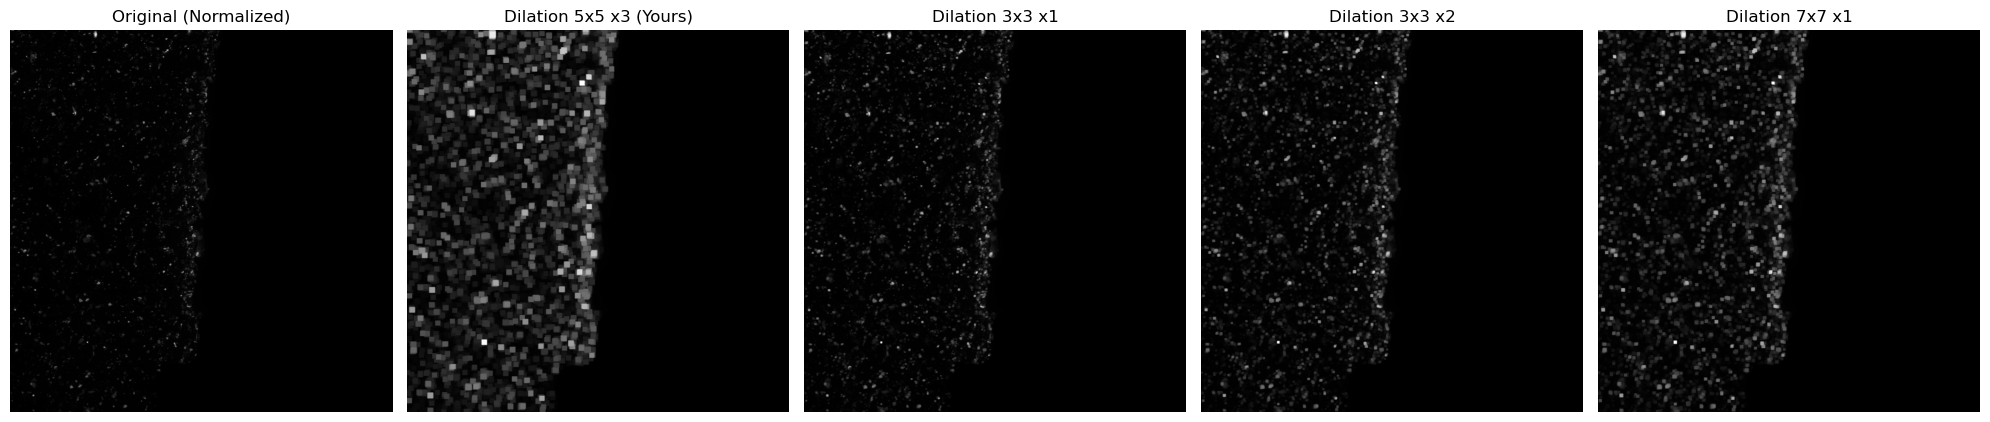

In [3]:
compare_dilations("/home/codingcarlos/Desktop/BNL SULI Summer 2025/4-UCM/mosaic_stitched_200um/mosaic_200_Fe_merged.tiff")
